# Reconnaissance d'animaux et objets de la base de données CIFAR-10

## Import des librairies

In [4]:
import torch
import numpy as np
import torchvision.transforms as transforms
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output


In [5]:
device = torch.device("cuda:0")

In [6]:
# Import des bases de données d'entraînement et de test, et normalisation
# Les données de trainset définiront les poids et biais que l'on affecte au modèle
# Les données de testset  serviront à tester le modèle en conditions réelles (sur des images qu'il n'a jamais vues)
trainset = CIFAR10('./data',  train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
testset =  CIFAR10("./data", train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
print(testset)


Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [7]:
#définition du mode de chargement des données dans l'algorithme : images chargées par 4 [batch_size], prises dans une ordre aléatoire [shuffle = True]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)


In [8]:
class Net(nn.Module):
    
    def __init__(self):
        # Définition des fonctions que l'on va éxécuter pour
        #la propagation directe
        super(Net,self).__init__()
        #Convolutions; param : in_channels (nécessairement 3 pour le premier),
        # out_channels, taille du noyau de convolution
        self.conv1 = nn.Conv2d(3,16,3)
        
        # images : 32x32 -> 30x30
        
        # max_pool2d(x, (2,2)) ici
        
        # 15x15
        
        self.conv2 = nn.Conv2d(16,16,4)
                
        # 12x12 car noyau de convolution de taille 4
        
        self.normalize1 = nn.BatchNorm2d(16) # On peut normaliser les données
        self.normalize2 = nn.BatchNorm2d(16) 

        # max_pool2d(x, 2) ici
        
        # 6x6
        
        self.fc1 = nn.Linear(16*6*6, 120)
        self.fc2 = nn.Linear(120,120)
        self.fc3 = nn.Linear(120,10)
   

        # Fonction éxécutée pour la propagation
    def forward(self,x):
        
        # Première convolution
        x = self.conv1(x)
        
        x = self.normalize1(x)
        # Fonction d'activation pour éliminer les linéarités, relu est très
        #efficace lorsqu'il y a peu de couches de neurones
        x = F.relu(x)
        
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(x, (2, 2))
        
        # Deuxième convolution
        x = self.conv2(x)
        
        # Normalise les données
        x = self.normalize2(x)
        
        # Fonction d'activation
        x = F.relu(x)
        
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(x, 2)
        
        # Redimensionnement du vecteur x selon son nombre de lignes
        x = x.view(-1, self.num_flat_features(x))
    
        # Applique une transformation linéaire à l'entrée de dimensions 16*6*6
        #et retourne une sortie de taille 120
        x = self.fc1(x)
        
        # Fonction d'activation
        x = F.relu(x)
        
        # 120 -> 84
        x = self.fc2(x)
        
        # Fonction d'activation
        x = F.relu(x)
        
        # 84 -> 10; chaque nombre de 0 à 9 représente un animal/objet
        x = self.fc3(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features = num_features*s
        return num_features
    
net = Net()

In [9]:
#Définition de la fonction de Loss et de l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [10]:
train_loss, train_accuracy, test_accuracy = [], [], []
for epoch in range(2):  # loop over the dataset multiple times
    
    running_loss = 0.0
    counter = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # print statistics
        counter += 1
        if i % 5000 == 4999:    # update every 5000 mini-batches

            correct1 = 0
            total1 = 0
            correct2 = 0
            total2 = 0
            
            with torch.no_grad():
                for data in trainloader:
                    images, labels = data
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total1 += labels.size(0)
                    correct1 += (predicted == labels).sum().item()
            train_accuracy.extend([correct1/total1])
            
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total2 += labels.size(0)
                    correct2 += (predicted == labels).sum().item()
            test_accuracy.extend([correct2/total2])
            
    train_loss.extend([running_loss/counter])
    running_loss = 0.0
            
plt.figure(figsize=(9, 3))
ax = plt.subplot(132)
ax.plot(train_accuracy)
ax.set_title("Accuracy Train\n{}".format(train_accuracy[-1]))
ax.set_ylim(0, 1)
    
ax = plt.subplot(133)
ax.plot(test_accuracy)
ax.set_title("Accuracy Test\n{}".format(test_accuracy[-1]))
ax.set_ylim(0, 1)
    
ax = plt.subplot(131)
ax.plot(train_loss)
ax.set_title("Train Loss\n{}".format(train_loss[-1]))
    
plt.show()
print('Finished Training')



KeyboardInterrupt: 

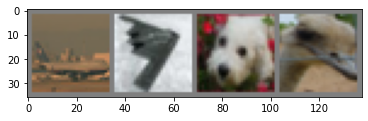

GroundTruth:  plane plane   dog  bird
Predicted:   ship plane   dog  bird


In [50]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [51]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 65 %


In [1]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

NameError: name 'torch' is not defined

NameError: name 'dataset_loader' is not defined